### Loading necessary library

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cv2, pickle, glob, os, pickle

from sklearn.model_selection import train_test_split

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Conv2D, LeakyReLU, Flatten, MaxPooling2D, Activation, Dropout, BatchNormalization
from keras.optimizers import Adamax, Adam
from keras.utils.vis_utils import plot_model
#from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
#from keras import backend as K
#import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
data_dir=os.path.join('/home/hasan/Data Set/Bengali Digit')

paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

In [3]:
paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

In [4]:
path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

### Function for Seperating Feature and Label data

In [5]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key


def get_data(paths_img, path_label=None,resize_dim=None):
    Feature=[] 
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
            
        gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0) #unblur
        img = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
        img = cv2.filter2D(img, -1, kernel)
        
        Feature.append(img)
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    
    Feature=np.array(Feature) # list to numpy
    if path_label is None:
        return Feature
    else:
        df = pd.read_csv(path_label) # read csv for labels
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        label =to_categorical(y_label,10) # transfrom integer value to categorical variable
        return Feature, label


In [6]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=32)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=32)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=32)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=32)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=32)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [7]:
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
print(f"Feature data shape = {X_train_all.shape} and Label Data shape = {y_train_all.shape}")

Feature data shape = (72045, 32, 32) and Label Data shape = (72045, 10)


In [8]:
# Test data reading
X_test_a=get_data(paths_test_a,resize_dim=32)
X_test_b=get_data(paths_test_b,resize_dim=32)
X_test_c=get_data(paths_test_c,resize_dim=32)
X_test_d=get_data(paths_test_d,resize_dim=32)
X_test_e=get_data(paths_test_e,resize_dim=32)
X_test_f=get_data(paths_test_f,resize_dim=32)
X_test_auga=get_data(paths_test_auga,resize_dim=32)
X_test_augc=get_data(paths_test_augc,resize_dim=32)

processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


In [9]:
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))
X_test_all.shape

(17626, 32, 32)

### Visualizing some images

In [10]:
visual_data = X_train_all

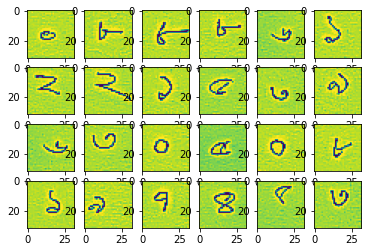

In [11]:
fig, ax = plt.subplots(4,6)
for i, axes in enumerate(ax.flat):
    axes.imshow(visual_data[i])   # cmap='bone'

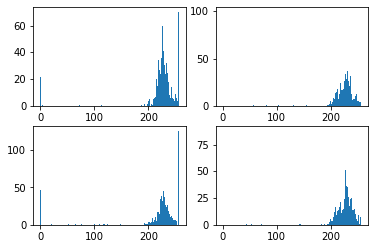

In [12]:
fig, ax = plt.subplots(2, 2)
for i, axes in enumerate(ax.flat):
    imgg=visual_data[i]
    hist = cv2.calcHist([imgg],[0],None,[256],[0,256])
    axes.hist(imgg.ravel(),256,[0,256])
    #plt.show()

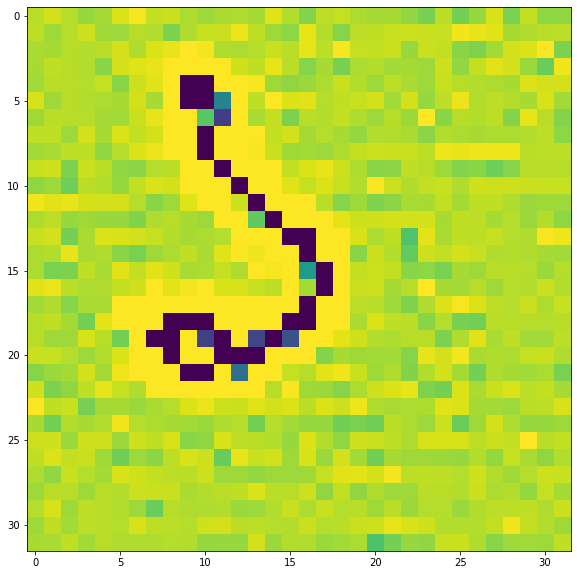

In [13]:
plt.figure(figsize=(10,10))
#for i in range(4):
plt.imshow(visual_data[5])

### Reshaping data

In [14]:
X_train_all = X_train_all.reshape(X_train_all.shape[0],32, 32,1).astype('float32')
X_test_all = X_test_all.reshape(X_test_all.shape[0],32, 32,1).astype('float32')
print(f"Shape of X_train_all = {X_train_all.shape} and Shape of X_test_all = {X_test_all.shape}")

Shape of X_train_all = (72045, 32, 32, 1) and Shape of X_test_all = (17626, 32, 32, 1)


### Normalization

In [15]:
X_train_all = X_train_all/255
X_test_all = X_test_all/255

### Train and Validation data

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_all, y_train_all, random_state=42, test_size=.2)

### Model

In [17]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(32,32,1), activation='relu', padding='same'))
model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))


In [18]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       5

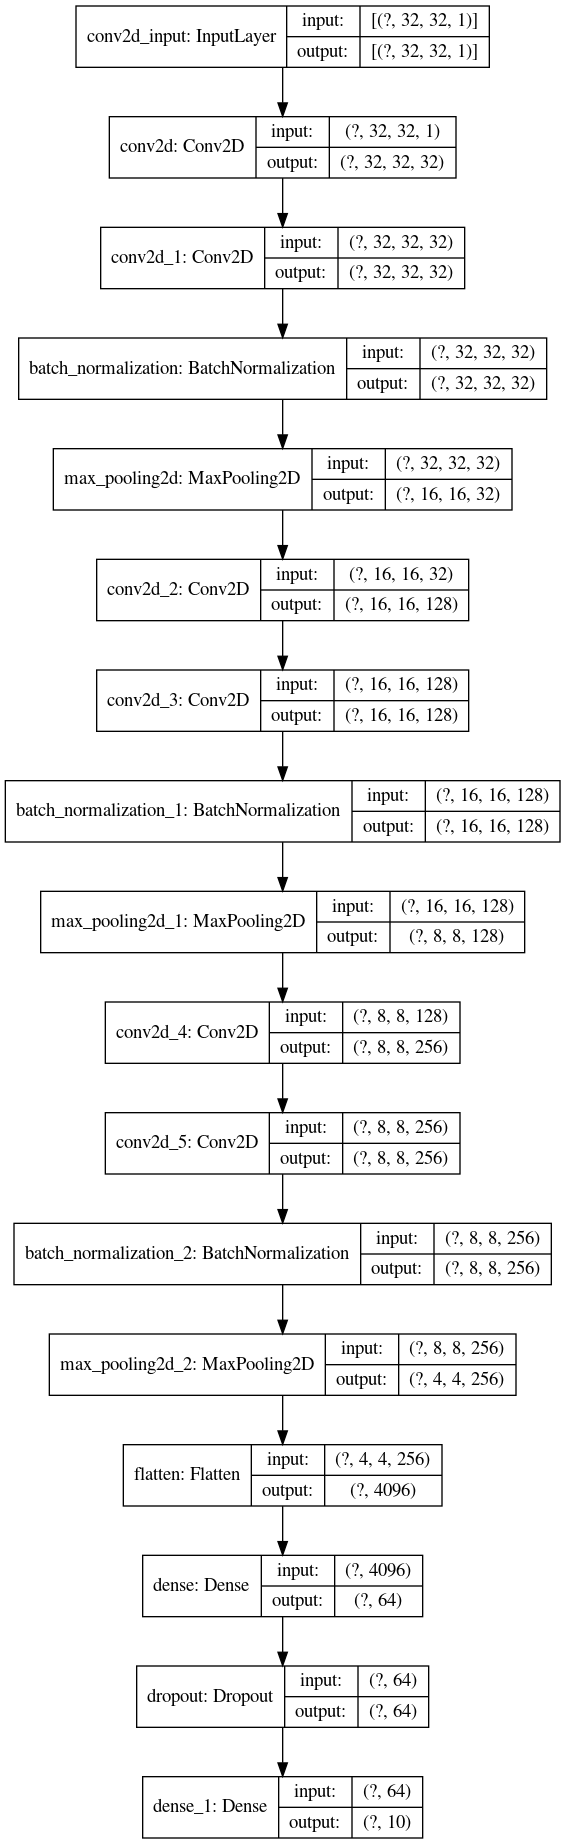

In [19]:
#plotting model
plot_model(model, show_shapes=True, to_file = 'digit_model.png')


In [20]:
# Compilation of the model
adam = Adam(learning_rate=1e-3)

model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=adam)

### Training the Model

In [21]:
h=model.fit(x=X_train, y=Y_train, 
            batch_size=64, 
            epochs=20, verbose=1, 
            validation_data=(X_val,Y_val),
            shuffle=True
            )

Epoch 1/20
901/901 [==============================] - 780s 866ms/step - loss: 0.8718 - accuracy: 0.6876 - val_loss: 0.3275 - val_accuracy: 0.8865
Epoch 2/20
901/901 [==============================] - 764s 848ms/step - loss: 0.1408 - accuracy: 0.9593 - val_loss: 0.1234 - val_accuracy: 0.9681
Epoch 3/20
901/901 [==============================] - 769s 853ms/step - loss: 0.1001 - accuracy: 0.9725 - val_loss: 0.0906 - val_accuracy: 0.9743
Epoch 4/20
901/901 [==============================] - 760s 843ms/step - loss: 0.0769 - accuracy: 0.9781 - val_loss: 0.1148 - val_accuracy: 0.9672
Epoch 5/20
901/901 [==============================] - 762s 845ms/step - loss: 0.0668 - accuracy: 0.9813 - val_loss: 0.0973 - val_accuracy: 0.9756
Epoch 6/20
901/901 [==============================] - 763s 847ms/step - loss: 0.0523 - accuracy: 0.9850 - val_loss: 0.1232 - val_accuracy: 0.9686
Epoch 7/20
901/901 [==============================] - 739s 820ms/step - loss: 0.0520 - accuracy: 0.9859 - val_loss: 0.0997 -

### predict with test data

In [22]:
predictions_prob=model.predict(X_test_all) # get predictions for all the test data

### Visualize some image with prediction

In [29]:
def imshow_group(X, y, y_pred=None, n_per_row=10, phase='processed'):
    '''helper function to visualize a group of images along with their categorical true labels (y) and prediction probabilities.
    Args:
        X: images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
        phase: If the images are plotted after resizing, pass 'processed' to phase argument. 
            It will plot the image and its true label. If the image is plotted after prediction 
            phase, pass predicted class probabilities to y_pred and 'prediction' to the phase argument. 
            It will plot the image, the true label, and it's top 3 predictions with highest probabilities.
    '''
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(20,3*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
#         img_sq=np.squeeze(img,axis=2)
#         plt.imshow(img_sq,cmap='gray')
        plt.imshow(img)
        if phase=='processed':
            plt.title(np.argmax(y[i]))
        if phase=='prediction':
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
            if y is not None:
                plt.text(img_dim/2, -4, 'true label: {}'.format(np.argmax(y[i])), 
                         horizontalalignment='center',verticalalignment='center')
        plt.axis('off')
    plt.show()

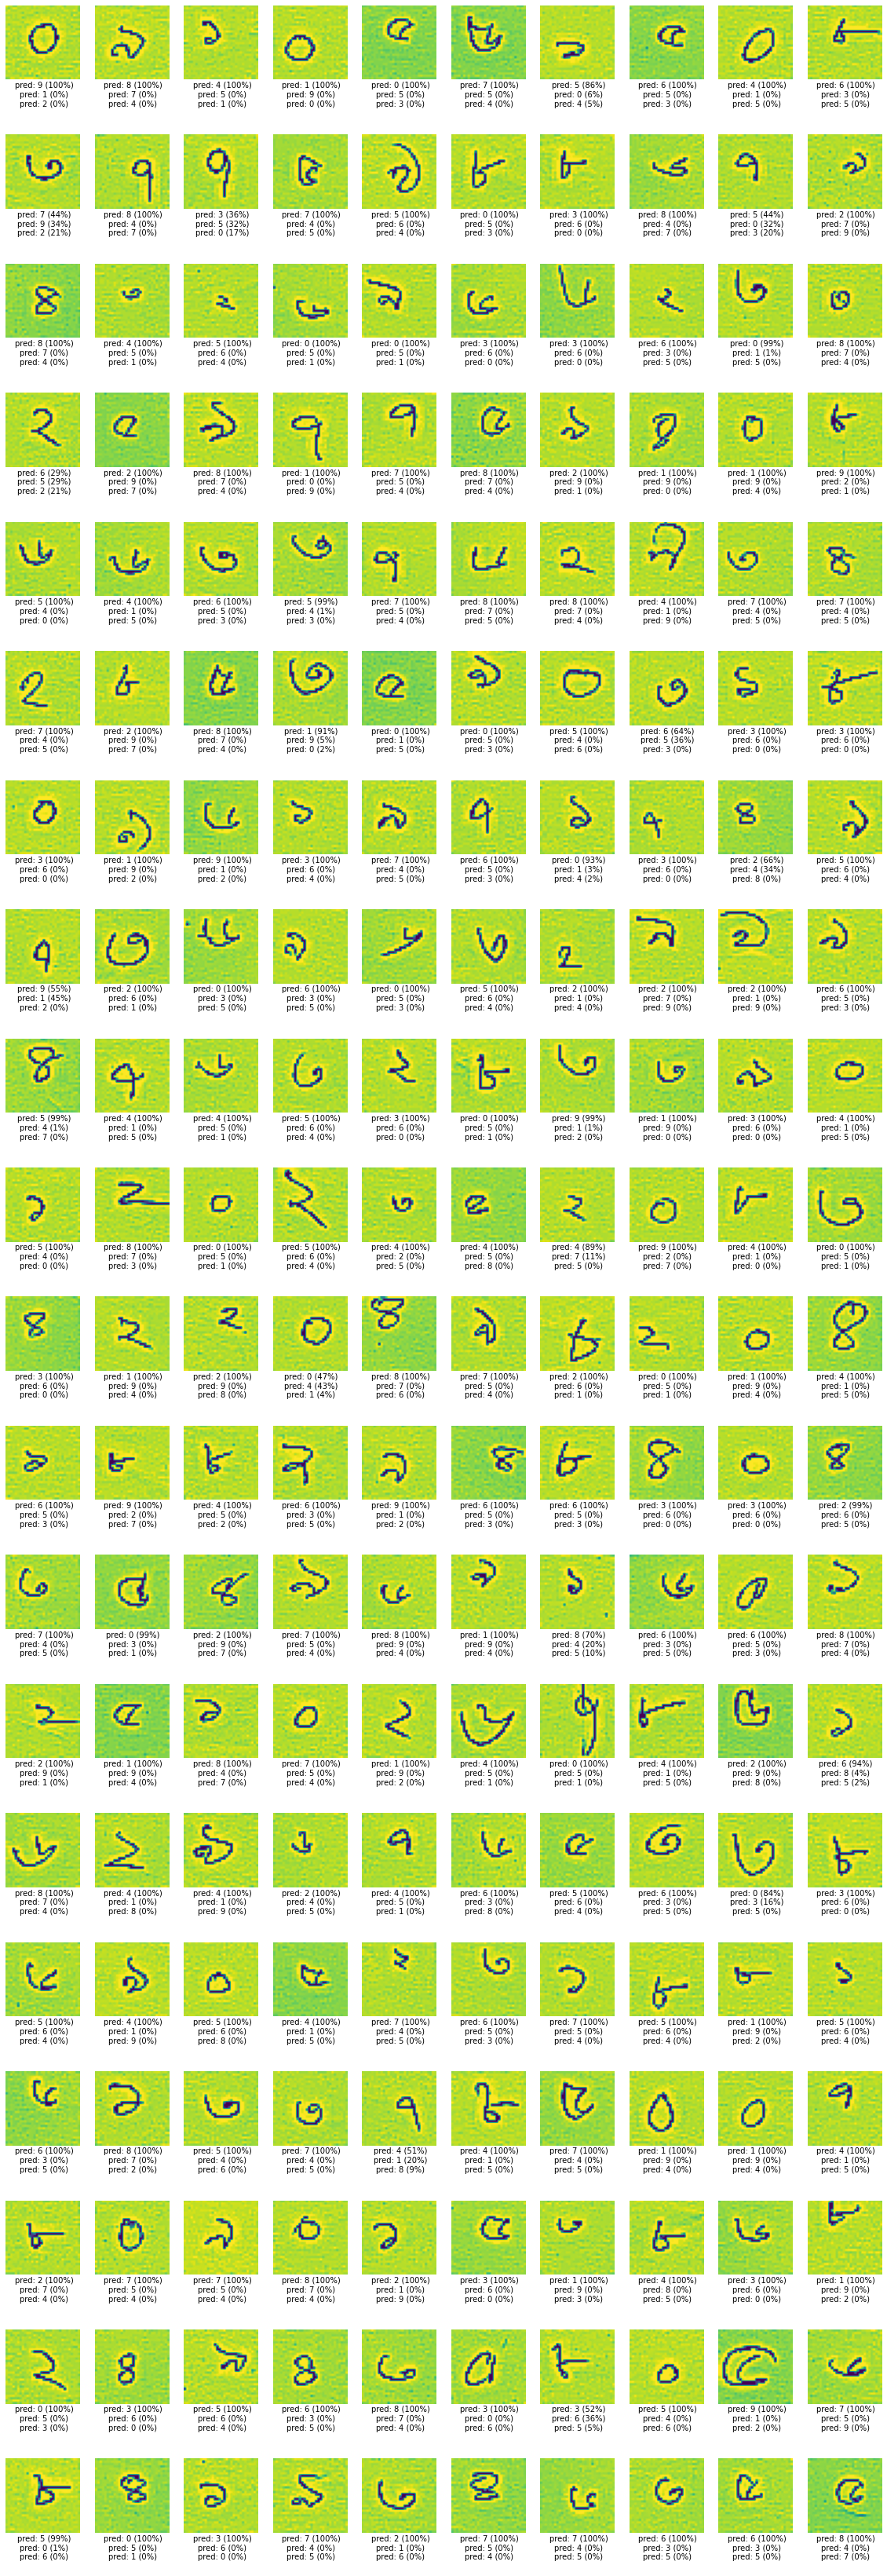

In [30]:
n_sample=200
np.random.seed(42)
ind=np.random.randint(0,len(X_test_all), size=n_sample)

imshow_group(X=visual_data[ind],y=None,y_pred=predictions_prob[ind], phase='prediction')

### Save Model

In [34]:
# serialize model to JSON
model_json = model.to_json()
with open("Bengali_Digit.json", "w") as json_file:
    json_file.write(model_json)

### CSV file of predicted images

In [35]:
def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)


In [36]:
labels=[np.argmax(pred) for pred in predictions_prob]

In [37]:
keys=[get_key(path) for path in paths_test_all]

In [38]:
create_submission(predictions=labels, keys=keys, path='Bengali_digit.csv')

In [40]:
prediction = pd.read_csv('Bengali_digit.csv')
prediction.head(100)

,key,label
0,a00312.png,6
1,a00945.png,3
2,a01639.png,4
3,a01949.png,9
4,a01792.png,3
...,...,...
95,a01490.png,0
96,a03428.png,9
97,a02516.png,7
98,a01754.png,4
